

#0 . Modelo de LGD

O objetivo desse estudo é comparar a metodologia tradicional de modelagem com a metodologia de Machine Learning. 

*   V. 20220927 - tudo OK nos itens 1 e 2
*   V. 20221003 - tudo OK até o item 3
*   V. 20221011 - Finalização do item 4






Aqui são descritos os passos relacionados à preparação dos dados e analises quantitativas. O objetivo é viabilizar a replicabilidade do estudo por outros pesquisadores e terem a oportunidade de desafiar a metodologia utilizada.

Neste estudo são avaliadas operações realizadas pelo Lending Club, uma empresa com grande relevância no mercado de financiamento Peer-to-Peer. Para quem quer conhecer mais, abaixo compartilhamos o link.

[Site da empresa](https://www.lendingclub.com/)

Os dados foram obtivos da plataforma Kagle e podem ser obtidos no link abaixo. No link també é disponibilizado o dicionário de dados da base.

[Dados](https://www.kaggle.com/code/ztrimus/loan-repayment-prediction/data?select=Loan_status_2007-2020Q3.gzip)

As bibliotecas, tanto instalação quanto importação, serão carregadas conforme forem utilizadas. Todo o desenvolvimento foi realizado com a utilização do **Python** na ferramenta **Colaboratory** do Google.

Inicialmente deve-se escolher rodar a maquina TPU, para reduzir o risco de falta de memória RAM.

Inicialmente são instaladas algumas bibliotecas necessárias à modelagem **(após a instalação delas no COLAB é necessário reuniniar o ambiente)** e depois é feita a conexão com o Google Drive, para acesso ao arquivo inicial.

O processamento do módulo 1 é pré-requisito para os demais. Os demais são processados de forma independente. Importante destacar que os tratamentos dos dados do item 3 são os mesmos no item 4.




In [ ]:
!pip install scikit-learn
!pip install auto-sklearn
!pip install PipelineProfiler

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 . Importando e tratando os dados 

### Nesta etapa descrevemos os procedimentos iniciais para definição da amostra de desenvolvimento e validação.


Conecta o google drive ao ambiente de trabalho

## 1.1 Importanto observações relevantes

Devido ao tamanho da base, ela é importada por partes nessa etapa foram mantidos apenas os registros elegíveis à apuração do LGD, pelo critéio `loan_status`.

O total de colunas/variáveis da base original é 141 e após a exclusão dos registros que não foram a default, a base é reduzida de **2.925.494** para **363.309** registros.

Nesta etapa também foram excluídas 31 observações devido ao principal ter sido 100% recuperado antes do default. Nessa situação o denominador do LGD=0. Isso reduz a base ara **363.278** registros.


In [2]:
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)     # ajuste da visualização de tabela para todas as colunas
pd.set_option('display.max_rows', None)        # ajuste da visualização de tabela para todas as linhas
pd.set_option('mode.chained_assignment', None) # evita o aviso de processamento do Pandas

# Importa os dados a partir do google drive e faz os tratamentos da variável resposta, gerando a base LGD
os.chdir('/content/drive/My Drive/Colab Notebooks/')
df = pd.read_csv('lgd.csv.zip', compression='zip', low_memory=False, index_col=0)

# Importa os dados a partir do google drive e faz os tratamentos da variável resposta, gerando a base LGD
df0 = pd.read_csv('Loan_status_2007-2020Q3.zip', compression='zip', low_memory=False, index_col=0, nrows = 1500000)
df1 = df0[df0['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])] 
df2 = pd.read_csv('Loan_status_2007-2020Q3.zip', compression='zip', low_memory=False, index_col=0, skiprows=[i for i in range(1,1500000)])
df3 = df2[df2['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])] 
df = df1.append(df3, ignore_index=True)

# df0.shape (1500000, 141)
# df1.shape (133481, 141)
# df2.shape (1425494, 141)
# df3.shape (229828, 141)
# df.shape (363309, 141)
del df0, df1, df2, df3

# Exclusão dos 31 casos onde não é possível apurar o LGD
df = df[(df['loan_amnt']-df['total_rec_prncp'])>0] 
# df.shape (363278, 141)

Nesta etapa é construída a variável LGD e avaliada a sua distribuição ao longo dos anos no que se refere à forma, média `lgd` e percentual que apresenta 100% (ou seja, as situações onde nada foi recuperado `ldg_d`). A variável foi censurada em -0,3 porém o impacto foi em apenas 17 operações mantidas na base.

Pelo Gráfico abaixo observamos que apresenta certa estabilidade apenas no período entre 2014 e 2017. Antes de 2014 a carteira era bem pouco representativa e após 2017 o LGD piora muito, provavelmente devido ao menor período para acompanhamento da recuperação.

Dessa forma, optamos por seguir apenas com o período de **2014** a **2017**, reduzindo a amostra de **363.278** para **266.515** empréstimos.



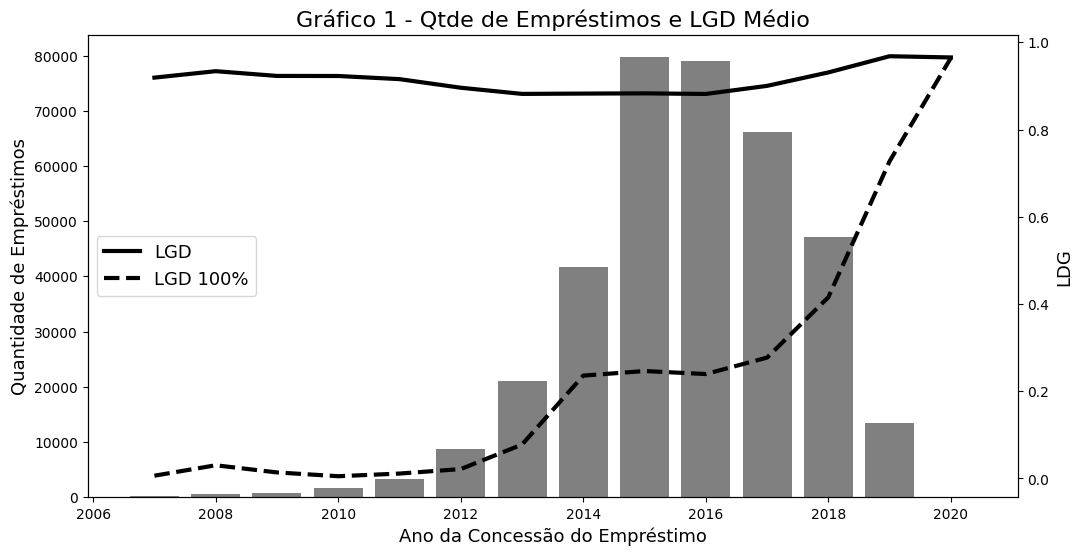

In [3]:
# Transforma a informação de data de concessão do crédito e deleta a variável original, bem como o status do empréstimo
df['year'] = pd.DatetimeIndex(df['issue_d']).year

# Construção do LGD
df['lgd'] = 1-((df['recoveries']-df['collection_recovery_fee'])/(df['loan_amnt']-df['total_rec_prncp']))
df['lgd'] = np.where(df['lgd'] < -0.3, -0.3, df['lgd']) # 17 censurados
df['lgd_d'] = np.where(df['lgd']==1, 1, 0)

avaliacao = df.groupby(['year'], as_index=False).agg({'id':'count', 'lgd': np.mean, 'lgd_d': np.mean})
plt.style.use('default')
fig, ax = plt.subplots(figsize = (12,6))
plt.title('Gráfico 1 - Qtde de Empréstimos e LGD Médio', fontsize = 16)
plt.xlabel('Ano da Concessão do Empréstimo', fontsize = 13)
ax.bar(avaliacao['year'], avaliacao['id'], color="grey")
ax2 = ax.twinx()
ax2.plot(avaliacao['year'], avaliacao['lgd'], color="black", linestyle='-', linewidth=3, label = 'LGD')
ax2.plot(avaliacao['year'], avaliacao['lgd_d'], color="black", linestyle='--', linewidth=3, label = 'LGD 100%')
ax.set_ylabel('Quantidade de Empréstimos', color = 'black', fontsize = 13)
ax2.set_ylabel('LDG', color = 'black', fontsize = 13)
plt.legend(fontsize = 13, loc=6)
plt.show()

Por fim, foi analisada a distribuição do LGD por ano e ela se manteve estável, depois foi avaliada se a renda não verificada deveria ser excluída, conforme artigo `P2P`, e notamos que não há diferença no nível de LGD entre os tipos de verificação. Finalmente incluímos os custos de recuperação referente ao comissionamento e vimos que, em média, representam 17,5% da recuperação observada e tem comportamento estável ao longo dos anos.

Foram mantidas as novas variáveis `year` e `lgd`, levando a base para 143 variáveis. A variável auxiliar `lgd_d` foi excluída.


In [4]:
del avaliacao
df = df.drop(columns=['lgd_d'])
df = df[df.year.isin([2014, 2015, 2016, 2017])]
df.shape #df.shape (266515, 143)

(266515, 143)

<Figure size 640x480 with 0 Axes>

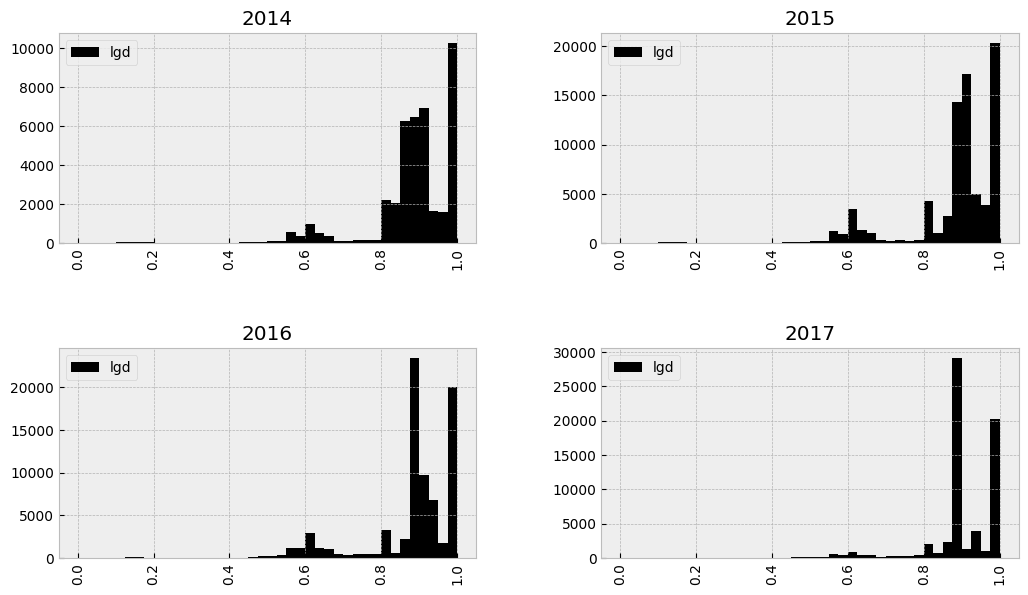

In [5]:
fig = plt.figure();
plt.style.use('bmh')
df.hist(column='lgd', by='year', grid=False, histtype='barstacked', bins=40, sharey=False, legend=True, color='black', range=[0,1], figsize = (12, 7))
plt.show()

In [6]:
total = df.groupby(['year'], as_index=False).agg({'id':'count', 'collection_recovery_fee': np.sum, 'recoveries': np.sum, 'lgd': np.mean})
total['prop'] =  total['collection_recovery_fee']/total['recoveries']
total = total.drop(columns=['collection_recovery_fee','recoveries'])
total

,year,id,lgd,prop
0,2014,41744,0.882486,0.165219
1,2015,79690,0.882989,0.178740
2,2016,78998,0.881632,0.176490
3,2017,66083,0.900175,0.175733


In [7]:
del total
df.groupby(['verification_status'], as_index=False).agg({'id':'count', 'lgd': np.mean})

,verification_status,id,lgd
0,Not Verified,59263,0.889056
1,Source Verified,114942,0.887496
2,Verified,92310,0.884397



## 1.2 Realizando do tratamentos iniciais nas informações

Nesta etapa, alguns tratamentos gerais e exclusões são feitos antes de iniciar os diferentes testes. Em resumo, das 143 variáveis são excluídas 52, conforme tabela abaixo:

variável | Motivo da exclusão | Detalhe 
-|-|-
id | identificação da operação | id
funded_amnt | idêntica à variável "loan_amnt" | 
emp_title | muito granular | 
issue_d | construída a variável year | 
loan_status | todos os valores iguais | charge-off
pymnt_plan | todos os valores iguais | letra n
url | identificação da operação | endereço web
title | muito granular | 
zip_code | muito granular | 
addr_state | muito granular | 
initial_list_status | caracteriza o investidor e não o tomador | 
out_prncp | todos os valores iguais | 0
out_prncp_inv | todos os valores iguais | 0
total_pymnt_inv | caracteriza o investidor e não o tomador | 
recoveries | variável futura, pós lgd | 
collection_recovery_fee | variável futura, pós lgd | 
last_pymnt_d | variável futura, pós lgd | 
last_pymnt_amnt | variável futura, pós lgd | 
next_pymnt_d | todos os valores iguais | 0
last_credit_pull_d | variável futura, pós lgd | 
policy_code | todos os valores iguais | 1
annual_inc_joint | baixo preenchimento | 2,7%
dti_joint | baixo preenchimento | 2,7%
verification_status_joint | baixo preenchimento | 2,7%
num_tl_30dpd | baixo preenchimento | 0,37%
revol_bal_joint | baixo preenchimento | 2,2%
sec_app_fico_range_low | baixo preenchimento | 2,2%
sec_app_fico_range_high | baixo preenchimento | 2,2%
sec_app_earliest_cr_line | baixo preenchimento | 2,2%
sec_app_inq_last_6mths | baixo preenchimento | 2,2%
sec_app_mort_acc | baixo preenchimento | 2,2%
sec_app_open_acc | baixo preenchimento | 2,2%
sec_app_revol_util | baixo preenchimento | 2,2%
sec_app_open_act_il | baixo preenchimento | 2,2%
sec_app_num_rev_accts | baixo preenchimento | 2,2%
sec_app_chargeoff_within_12_mths | baixo preenchimento | 2,2%
sec_app_collections_12_mths_ex_med | baixo preenchimento | 2,2%
hardship_flag | baixo preenchimento | 0,003%
hardship_type | baixo preenchimento | 2,4%
hardship_reason | baixo preenchimento | 2,4%
hardship_status | baixo preenchimento | 2,4%
deferral_term | baixo preenchimento | 2,4%
hardship_amount | baixo preenchimento | 2,4%
hardship_start_date | baixo preenchimento | 2,4%
hardship_end_date | baixo preenchimento | 2,4%
payment_plan_start_date | baixo preenchimento | 2,4%
hardship_length | baixo preenchimento | 2,4%
hardship_dpd | baixo preenchimento | 2,4%
hardship_loan_status | baixo preenchimento | 2,4%
orig_projected_additional_accrued_interest | baixo preenchimento | 2,4%
hardship_payoff_balance_amount | baixo preenchimento | 2,4%
hardship_last_payment_amount | baixo preenchimento | 2,4%
debt_settlement_flag | variável futura, pós lgd |


Outras 5 variáveis auxiliares são criadas, que indicam se o preenchimento de outra é nulo e foi transformado em zero. São elas:


variável original | Variável indicativa criada  
-|-
mths_since_last_delinq | mths_since_last_delinq_null 
mths_since_last_record |mths_since_last_record_null
mths_since_last_major_derog | mths_since_last_major_derog_null
mths_since_recent_bc_dlq | mths_since_recent_bc_dlq_null
mths_since_recent_revol_delinq | mths_since_recent_revol_delinq_null

Finalmente são criadas Dummies para as variáveis listadas abaixo:

*   grade
*   home_ownership
*   purpose

O que deixa a base final com **112** variáveis, incluindo o ano, que será usado apenas para controle das amostras posteriormente. 


In [8]:
# transformando o plano de pagamento em numérico e depois em dummy = 1 (60 meses)
df['term_c'] = np.where(pd.to_numeric(df['term'].str.replace(' months', ''))==60, 1, 0)

# transformando a taxa de juros em numérico
df['int_rate_n'] = pd.to_numeric(df['int_rate'].str.replace('%', ''))

# Tratando a variável subgrade, de categorias para contínua
a = {'A1':1,'A2':2,'A3':3,'A4':4,'A5':5,'B1':6,'B2':7,'B3':8,'B4':9,'B5':10,'C1':11,'C2':12,'C3':13,'C4':14,'C5':15,\
     'D1':16,'D2':17,'D3':18,'D4':19,'D5':20,'E1':21,'E2':22,'E3':23,'E4':24,'E5':25,\
     'F1':26,'F2':27,'F3':28,'F4':29,'F5':30,'G1':31,'G2':32,'G3':33,'G4':34,'G5':35}
df['sub_grade_n'] = df['sub_grade'].map(a)

# Tratando o texto da variável tempo de emprego
df['emp_length_n'] = df['emp_length'].str.replace('\+ years', '') #subst palavra por vazio
df['emp_length_n'] = df['emp_length_n'].str.replace('< 1 year', str(0)) #subst <1 ano por 0 (zero)
df['emp_length_n'] = df['emp_length_n'].str.replace('n/a',  str(0)) #subst S/I por 0 (zero)
df['emp_length_n'] = df['emp_length_n'].str.replace(' years', '') #subst palavra por vazio
df['emp_length_n'] = df['emp_length_n'].str.replace(' year', '') #subst palavra por vazio
df['emp_length_n'] = pd.to_numeric(df['emp_length_n']) #Transforma em numérico
df['emp_length_n'] = np.where(df['emp_length_n']==0, 0.5, df['emp_length_n']) # Transforma 0 anos em 0.5 
df['emp_length_n'].fillna(0, inplace=True) # nos casos sem informação assume-se 0 (pior condição)

# Categorizada em verificada e não verificada
b = {'Not Verified':0,'Source Verified':1,'Verified':1}
df['verification_c'] = df['verification_status'].map(b)

# Tratando o dti - endividamento
df['dti'].fillna(0, inplace=True) #85 nulas

# Data da primeira linha de crédito, transformado em tempo de relacionamento no mercado em anos base 2017
df['earliest_cr_line_n'] = 2017 - pd.DatetimeIndex(df['earliest_cr_line']).year

# Preenchendo com 0 os valores nulos e criando indicador de não ocorrencia
df['mths_since_last_delinq_null'] = np.where(df['mths_since_last_delinq'].isnull(),1,0) 
df['mths_since_last_delinq'].fillna(0, inplace=True) #125323 nulas
df['mths_since_last_record_null'] = np.where(df['mths_since_last_record'].isnull(),1,0) 
df['mths_since_last_record'].fillna(0, inplace=True) #210424 nulas
df['mths_since_last_major_derog_null'] = np.where(df['mths_since_last_major_derog'].isnull(),1,0) 
df['mths_since_last_major_derog'].fillna(0, inplace=True) #183776 nulas

# Preenchendo com 0 os valores nulos e transforma a info em número ao invés de texto
df['revol_util_n'] = pd.to_numeric(np.where(df['revol_util'].isnull(),0,df['revol_util'].str.replace('%', '')))

# Categorizando variáveis para empréstimos conjuntos e preenchendo com 0 os valores nulos
c = {'Joint App':0,'Individual':1}
df['application_type_c'] = df['application_type'].map(c)

# Preenchendo nulos com zeros
df['open_acc_6m'].fillna(0, inplace=True) #117319 nulas
df['open_act_il'].fillna(0, inplace=True) #117319 nulas
df['open_il_12m'].fillna(0, inplace=True) #117319 nulas
df['open_il_24m'].fillna(0, inplace=True) #117319 nulas
df['mths_since_rcnt_il'].fillna(0, inplace=True) #121784 nulas
df['total_bal_il'].fillna(0, inplace=True) #117319 nulas
df['il_util'].fillna(0, inplace=True) #136010 nulas
df['open_rv_12m'].fillna(0, inplace=True) #117319 nulas
df['open_rv_24m'].fillna(0, inplace=True) #117319 nulas
df['max_bal_bc'].fillna(0, inplace=True) #117319 nulas
df['all_util'].fillna(0, inplace=True) #117319 nulas
df['inq_fi'].fillna(0, inplace=True) #117319 nulas
df['total_cu_tl'].fillna(0, inplace=True) #117319 nulas
df['inq_last_12m'].fillna(0, inplace=True) #117319 nulas
df['avg_cur_bal'].fillna(0, inplace=True) #5 nulas
df['bc_open_to_buy'].fillna(0, inplace=True) #2929 nulas
df['bc_util'].fillna(0, inplace=True) #3090 nulas
df['mo_sin_old_il_acct'].fillna(0, inplace=True) #7939 nulas
df['num_tl_120dpd_2m'].fillna(0, inplace=True) #16062 nulas
df['percent_bc_gt_75'].fillna(0, inplace=True) #3009 nulas

# Categorizando variáveis atrasos em contas internas e preenchendo com 0 os valores nulos
df['mths_since_recent_bc'].fillna(0, inplace=True) #2764 nulas
df['mths_since_recent_bc_dlq'].fillna(0, inplace=True) #196726 nulas
df['mths_since_recent_bc_dlq_null'] = np.where(df['mths_since_recent_bc_dlq'].isnull(),1,0) 
df['mths_since_recent_inq'].fillna(0, inplace=True) #19513 nulas
df['mths_since_recent_revol_delinq'].fillna(0, inplace=True) #196726 nulas
df['mths_since_recent_revol_delinq_null'] = np.where(df['mths_since_recent_revol_delinq'].isnull(),1,0) 

df = df[['lgd','year','loan_amnt','funded_amnt_inv','term_c','int_rate_n','installment','grade','sub_grade_n',\
         'emp_length_n','home_ownership','annual_inc','verification_c','purpose','dti','delinq_2yrs',\
         'earliest_cr_line_n','fico_range_low','fico_range_high','inq_last_6mths','mths_since_last_delinq',\
         'mths_since_last_delinq_null','mths_since_last_record','mths_since_last_record_null','open_acc','pub_rec','revol_bal',\
         'revol_util_n','total_acc','total_pymnt','total_rec_prncp','total_rec_int','total_rec_late_fee',\
         'last_fico_range_high','last_fico_range_low','collections_12_mths_ex_med','mths_since_last_major_derog',\
         'mths_since_last_major_derog_null','application_type_c','acc_now_delinq','tot_coll_amt','tot_cur_bal','open_acc_6m',\
         'open_act_il','open_il_12m','open_il_24m','mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m',\
         'open_rv_24m','max_bal_bc','all_util','total_rev_hi_lim','inq_fi','total_cu_tl','inq_last_12m',\
         'acc_open_past_24mths','avg_cur_bal','bc_open_to_buy','bc_util','chargeoff_within_12_mths','delinq_amnt',\
         'mo_sin_old_il_acct','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mort_acc',\
         'mths_since_recent_bc','mths_since_recent_bc_dlq','mths_since_recent_bc_dlq_null',\
         'mths_since_recent_inq','mths_since_recent_revol_delinq','mths_since_recent_revol_delinq_null',\
         'num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl',\
         'num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m',\
         'num_tl_90g_dpd_24m','num_tl_op_past_12m','pct_tl_nvr_dlq','percent_bc_gt_75','pub_rec_bankruptcies',\
         'tax_liens','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit']]

# Cria as dummies e concatena na tabela final 
dummies = [pd.get_dummies(df['grade'], prefix = 'grade', prefix_sep = ':'),
           pd.get_dummies(df['home_ownership'], prefix = 'home_ownership', prefix_sep = ':'),
           pd.get_dummies(df['purpose'], prefix = 'purpose', prefix_sep = ':')]

dummies = pd.concat(dummies, axis = 1)
df1 = pd.concat([df, dummies], axis = 1)
df1 = df1.drop(['grade','grade:G','home_ownership','home_ownership:RENT','purpose','purpose:small_business'], axis = 1)
del df, dummies
df1.shape # (266515, 112)

(266515, 112)


## 1.3 Carregando programas auxiliares

Aqui são pré-processadas algumas funções que auxiliarão as análises mais à frente

In [9]:
# Função usado para avaliar a performance nas diferentes amostras
def reg_metrics(y, y_pred, X):
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    import scipy.stats

    mae = mean_absolute_error(y,y_pred)
    rmse = np.sqrt(mean_squared_error(y,y_pred)) #penaliza mais a existência de outliers, ver o artigo acima
    r2 = r2_score(y,y_pred)
    # Scikit-learn doesn't have adjusted r-square, hence custom code
    n = y_pred.shape[0]
    k = X_train.shape[1]
    adj_r_sq = 1 - (1 - r2)*(n-1)/(n-1-k)

    df_y = pd.DataFrame(y, columns = ['y'])
    r = scipy.stats.pearsonr(df_y['y'].tolist(),y_pred.tolist())[0] # Pearson's r
    rho = scipy.stats.spearmanr(df_y['y'].tolist(),y_pred.tolist()).correlation   # Spearman's rho
    tau = scipy.stats.kendalltau(df_y['y'].tolist(),y_pred.tolist()).correlation  # Kendall's tau

    print('mae:',round(mae,7),'rmse:',round(rmse,7),'R2:',round(r2,7),'R2_Ajustado:', round(adj_r_sq,7),\
          'Qtd:',n, 'r:', round(r,7), 'rho:', round(rho,7), 'tau:', round(tau,7))

In [10]:
# Gráfico de dispersão dos valores observados e estimados nas amostras de treinamento e validação
def plot_train_val(y_pred_train, y_train, y_pred, y):
  fig = plt.figure();
  plt.style.use('default')
  plt.scatter(y_pred_train, y_train,s=3, marker='D', label="Train", c='dimgray')
  plt.scatter(y_pred, y, s=2, marker='.', label="Test", c='navy') 
  plt.xlabel("Predicted value")
  plt.ylabel("True value")
  plt.legend()
  plt.plot([-0.1, 1.1], [-0.1, 1.1], c='k', zorder=0) 
  plt.plot([0, 0], [0, 1], c='grey', zorder=0)
  plt.plot([0, 1], [1, 1], c='grey', zorder=0)
  plt.plot([1, 1], [1, 0], c='grey', zorder=0)
  plt.plot([1, 0], [0, 0], c='grey', zorder=0)
  plt.xlim([-0.1, 1.1])
  plt.ylim([-0.1, 1.1])
  plt.tight_layout()
  return plt.show()

In [11]:
# Função para avaliar a multicolinearidade e influência de outliers, principalmente nas regressões linerares
# Informa a matriz de entrada em "X" e a quantidade de variáveis a serem listadas em "Z"
def vif(X,Z):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i).round(decimals=1)
                              for i in range(len(X.columns))]
    vif_data = vif_data.sort_values(by=['VIF'], ascending=False).head(Z)                          
    print(vif_data)


# 2 . Desenvolvimento ML usando AutoSklearn





Existem várias auternativas de Auto-ML no Python. Optou-se aqui pelo uso autosklearn, principalmente pela baixa necessidade de parametrização pelo
usuário e pela sua performance comparativa em termos de acurácia e tempo de
processamento. Para avaliar a performance do algoritmo promovemos as seguintes 
variações no processamento.

*   **Tamanho da amostra:** Aqui foram 3 variações testadas, 100%, 10% e 2%, o que gerou amostras com 9.7147, 9.714 e 1943 observações respectivamente. O tamanho é definido no bloco a seguir, bastando comentar/descomentar o trecho logo após a importação da biblioteca.

*   **Tempo:** O algoritmo foi testado em 1h (7mins máximo por modelo) e 3h (20mins máximos por modelo. A parametrização dessa etapa é feita diretamente na função `automl` do 2º bloco à seguir. Ela é definida em segundos. 

Para evitar falha por falta de memória RAM, o ideal é que os blocos dessa etapa sejam processados individualmente. Nos blocos seguintes são processadas as saídas de cada modelo.



In [ ]:
from sklearn.model_selection import train_test_split

# seleciona a base de deselvolvimento e define o tamanho da amostra.
df_des = df1[df1.year.isin([2014,2015])].drop(columns=['year'])
#df_des = df_des.sample(frac =.10, replace = False, random_state = 2) #10%
#df_des = df_des.sample(frac =.02, replace = False, random_state = 2) #2%

y = df_des.pop('lgd').to_numpy() 
X = df_des.to_numpy()

# Determinação da amostra de treinamento e  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=120) # 80% training and 20% test

# Separa as amostras de validação out-of-time
X_2016 = df1[df1['year']==2016].drop(columns=['year']) #(78998, 111)
X_2017 = df1[df1['year']==2017].drop(columns=['year']) #(66083, 111)
y_2016 = X_2016.pop('lgd').to_numpy() 
X_2016 = X_2016.to_numpy()
y_2017 = X_2017.pop('lgd').to_numpy() 
X_2017 = X_2017.to_numpy()

(X_train.shape, y_train.shape, X_test.shape, y_test.shape,)

In [ ]:
import autosklearn.regression

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=10800,  # 3 hs = 10800s / 1h = 3600s
    per_run_time_limit = 900,       # 20 min = 900s / 7 min = 420s
    seed = 120,
    metric = autosklearn.metrics.r2, #r2, mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_squared_log_error, median_absolute_error
    memory_limit = 6000,
)
automl.fit(X_train, y_train, feat_type=['Numerical']*110)

In [ ]:
# Retorna o valor previsto nas diferentes amostras
y_pred_train = automl.predict(X_train)
y_pred_test = automl.predict(X_test)
y_pred_2016 = automl.predict(X_2016)
y_pred_2017 = automl.predict(X_2017)

#View the models found by auto-sklearn DETAILED
automl.leaderboard(detailed = True, ensemble_only=True)

In [ ]:
# summarize performance
print(automl.sprint_statistics())
print('')
# Print the final ensemble constructed by auto-sklearn
from pprint import pprint
pprint(automl.show_models(), indent=4)

In [ ]:
# Gera as métricas de qualidade da Base
reg_metrics(y_train, y_pred_train, X_train)
reg_metrics(y_test, y_pred_test, X_test)
reg_metrics(y_2016, y_pred_2016, X_2016)
reg_metrics(y_2017, y_pred_2017, X_2017)

In [ ]:
import PipelineProfiler
profiler_data= PipelineProfiler.import_autosklearn(automl)
PipelineProfiler.plot_pipeline_matrix(profiler_data)

In [ ]:
plot_train_val(y_pred_train, y_train, y_pred_2017, y_2017)

# 3 . Método Tradicional com seleção automática de variáveis


## 3.1 Árvore de Decisão

Nessa etapa, são desenvolvidos os modelos de LGD chamados tradicionais. Como a distribuição não é Bi-Modal (o que ocorre com o LGD de algumas carteiras de crédito), optamos por utilizar apenas os métodos de Árvore de Decisão e Regressão Linear.  

Nesta etapa apresentamos os resultados para a **Árvore de Decisão.**Aqui criadas variáveis ligadas ao LGD não presentes na base original. São elas:

variável criada | Explicação  
-|-
ead | valor da dívida no momento do default 
ead_ind | ead / renda do devedor
ead_loan | ead / valor original tomado

Além disso, algumas observações com valores extremos para as variáveis `dti` e `ead_inc` são censuradas. Finalmente as variáveis `ead` e `loan_amnt` são transformadas em milhares, para facilitar a leitura dos resultados na etapa posterior de regressão linear.

Dessa forma, a base passa de **112** para **115** variáveis.

A metodologia utilizada é a de maximização do R2 (existem várias outras metodologias disponíveis, conforme link: [Métodos](https://https://scikit-learn.org/stable/modules/model_evaluation.html) ).




In [ ]:
# Valor do empréstimo em milhares de dólares e criação da variável EAD e EAD/Renda
df1['ead'] = (df1['loan_amnt']-df1['total_rec_prncp'])/1000
df1['ead_inc'] = (df1['loan_amnt']-df1['total_rec_prncp'])/df1['annual_inc']
df1['ead_inc'] = np.where(df1['ead_inc'] > 30, 30, df1['ead_inc']) # 89 censurados
df1['ead_loan'] = (df1['loan_amnt']-df1['total_rec_prncp'])/df1['loan_amnt']
df1['loan_amnt'] = df1['loan_amnt']/1000
df1['dti'] = np.where(df1['dti']>200, 200, df1['dti']) #56 censurados

df1.shape #(266515, 115)

(266515, 115)

### 3.1.1 Processamento recursivo do bloco

In [ ]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import RFECV

# Separa as amostras iniciais
# ----------------------------------------
df_des = df1[df1.year.isin([2014,2015])].drop(columns=['year'])
#df_des = df_des.sample(frac =.10, replace = False, random_state = 2) #10%
df_des = df_des.sample(frac =.02, replace = False, random_state = 2) #2%

# Separa as amostras de validação out-of-time
df_2016 = df1[df1['year']==2016].drop(columns=['year'])
df_2017 = df1[df1['year']==2017].drop(columns=['year'])

feature_cols = df_des.drop(columns=['lgd']).columns.values.tolist()

X = df_des[feature_cols].to_numpy() 
X_aux = df_des[feature_cols] 
y = df_des[['lgd']].to_numpy() # Target variable
X_2016 = df_2016[feature_cols].to_numpy() 
y_2016 = df_2016[['lgd']].to_numpy() 
X_2017 = df_2017[feature_cols].to_numpy() 
y_2017 = df_2017[['lgd']].to_numpy() 

# Determinação da amostra de treinamento e  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=120) # 80% training and 20% test

# Create Decision Tree Regressor object (resposta contínua)
rfecv = RFECV(DecisionTreeRegressor(random_state=120), step=1, scoring="r2", cv=4, verbose=1, n_jobs = -1) 

# Train Decision Tree Classifer
rfecv = rfecv.fit(X_train,y_train)
# Predict the response for test dataset
y_pred_train = rfecv.predict(X_train)
y_pred_test = rfecv.predict(X_test)
y_pred_2016 = rfecv.predict(X_2016)
y_pred_2017 = rfecv.predict(X_2017)

In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)
features_kept = pd.DataFrame({'columns': X_aux.columns,
                             'Kept': rfecv.support_})
features_kept = features_kept[features_kept['Kept']==True] 
features_kept

In [ ]:
reg_metrics(y_train, y_pred_train, X_train)
reg_metrics(y_test, y_pred_test, X_test)
reg_metrics(y_2016, y_pred_2016, X_2016)
reg_metrics(y_2017, y_pred_2017, X_2017)

In [ ]:
import pylab as pl
pl.figure()
pl.xlabel("Number of features selected")
pl.ylabel("Cross validation score (nb of misclassifications)")
pl.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
pl.show()

In [ ]:
plot_train_val(y_pred_train, y_train, y_pred_2017, y_2017)

## 3.2 Regressão Linear

Nesta etapa apresentamos os resultados para a **Regressão Linear.** Aqui criadas utilizadas as mesmas variáveis da etapa anterior, no entanto 4 delas são transformadas em ln, minimizando o efeito de valores extremos e assimetria da distribuição. São elas:

1. `loan_amnt`
2. `int_rate_n`
3. `ead`
4. `annual_inc`

No caso da variável `annual_inc`, ela também foi censurada em valores extremos, mas o ocorreu em apenas **127** observações.

Como não há criação ou exclusão de qualquer variável, a tabela se mantém com a mesma estrutura. O trecho a seguir deve ser processado uma única vez. Na sequencia o modelo é repetido para diferentes amostras.

In [ ]:
# Trata algumas variáveis contínuas com domínio fora de 0-1
df1['loan_amnt'] = np.log(df1['loan_amnt'])
df1['int_rate_n'] = np.log(df1['int_rate_n'])
df1['ead'] = np.log(df1['ead'])

# Dividido por 1000, para deixar a renda em milhares de dólares anuais, censurando
df1['annual_inc'] = np.where(df1['annual_inc']<100, 100, df1['annual_inc']) #87 casos <$100
df1['annual_inc'] = np.where(df1['annual_inc']>1000000, 1000000, df1['annual_inc']) #40 casos >$1M
df1['annual_inc'] = df1['annual_inc']/1000 
df1['annual_inc'] = np.log(df1['annual_inc'])

#df1.shape (266515, 115)

### 3.2.1 Processamento recursivo do bloco

Nesta etapa é feita a escolha das variáveis mais importantes a serem utilizadas no modelo também utilizando o RFECV. Na sequencia é extraída a equação e as estatísticas de acurácia.

In [ ]:
from sklearn.linear_model import LinearRegression

# Separa as amostras iniciais
# ----------------------------------------
df_des = df1[df1.year.isin([2014,2015])].drop(columns=['year'])
des_train=df_des.sample(frac=0.8,random_state=120)
des_test=df_des.drop(des_train.index)

#df_des = df_des.sample(frac =.10, replace = False, random_state = 120) #10%
#des_train=df_des.sample(frac=0.8,random_state=2)
#des_test=df_des.drop(des_train.index)

df_des = df_des.sample(frac =.02, replace = False, random_state = 120) #2%
des_train=df_des.sample(frac=0.8,random_state=2)
des_test=df_des.drop(des_train.index)

# Separa as amostras de validação out-of-time
df_2016 = df1[df1['year']==2016].drop(columns=['year'])
df_2017 = df1[df1['year']==2017].drop(columns=['year'])

feature_cols = df_des.drop(columns=['lgd']).columns.values.tolist()

X_train = des_train[feature_cols]
y_train = des_train[['lgd']]
y_train.rename(columns = {'lgd':'y'}, inplace = True)

# Processo de seleção de variáveis
# https://scikit-learn.org/stable/modules/model_evaluation.html
rfecv = RFECV(
    estimator=LinearRegression(),
    min_features_to_select=5,
    step=5,
    n_jobs=-1,
    scoring="r2", 
    cv=5,
    verbose=2,
)

OLS = rfecv.fit(X_train, y_train)

feature_cols2 = X_train.columns[OLS.support_]

X_train = des_train[feature_cols2]
X_test = des_test[feature_cols2] 
y_test = des_test[['lgd']]
y_test.rename(columns = {'lgd':'y'}, inplace = True)
X_2016 = df_2016[feature_cols2] 
y_2016 = df_2016[['lgd']] 
y_2016.rename(columns = {'lgd':'y'}, inplace = True)
X_2017 = df_2017[feature_cols2] 
y_2017 = df_2017[['lgd']] 
y_2017.rename(columns = {'lgd':'y'}, inplace = True)

lr = LinearRegression()
results = lr.fit(X_train, y_train)
print("Training R-squared:", results.score(X_train, y_train))

Aqui o modelo é reprocessado apenas com as variáveis mantidas na etapa anterior e são extraídas as estatísticas de acerto.

In [ ]:
import statsmodels.api as sm
results = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(results.summary())

In [ ]:
y_pred_train = results.predict(sm.add_constant(X_train))
y_pred_test = results.predict(sm.add_constant(X_test))
y_pred_2016 = results.predict(sm.add_constant(X_2016))
y_pred_2017 = results.predict(sm.add_constant(X_2017))

reg_metrics(y_train, y_pred_train, X_train)
reg_metrics(y_test, y_pred_test, X_test)
reg_metrics(y_2016, y_pred_2016, X_2016)
reg_metrics(y_2017, y_pred_2017, X_2017)

In [ ]:
plot_train_val(y_pred_train, y_train, y_pred_2017, y_2017)

In [ ]:
vif(X_train,10)

## 3.3 Regressão Linear limitando o número de variáveis no modelo

Aqui é usada a função `RFE`, que otimiza o número da variáveis escolhidas para aquelas que mais contribuem para o acerto do modelo. O número de variáveis é limitado em **50** e **80**.

In [ ]:
from sklearn.feature_selection import RFE

# Separa as amostras iniciais
# ----------------------------------------
df_des = df1[df1.year.isin([2014,2015])].drop(columns=['year'])
des_train=df_des.sample(frac=0.8,random_state=120)
des_test=df_des.drop(des_train.index)

#df_des = df_des.sample(frac =.10, replace = False, random_state = 120) #10%
#des_train=df_des.sample(frac=0.8,random_state=2)
#des_test=df_des.drop(des_train.index)

df_des = df_des.sample(frac =.02, replace = False, random_state = 120) #2%
des_train=df_des.sample(frac=0.8,random_state=2)
des_test=df_des.drop(des_train.index)

# Separa as amostras de validação out-of-time
df_2016 = df1[df1['year']==2016].drop(columns=['year'])
df_2017 = df1[df1['year']==2017].drop(columns=['year'])

feature_cols = df_des.drop(columns=['lgd']).columns.values.tolist()

X_train = des_train[feature_cols]
y_train = des_train[['lgd']]
y_train.rename(columns = {'lgd':'y'}, inplace = True)

# Processo de seleção de variáveis
rfe = RFE(
    estimator=LinearRegression(),
    n_features_to_select=80,   # <-------------------
    step=1
)

OLS = rfe.fit(X_train, y_train)

feature_cols2 = X_train.columns[OLS.support_]

X_train = des_train[feature_cols2]
X_test = des_test[feature_cols2] 
y_test = des_test[['lgd']]
y_test.rename(columns = {'lgd':'y'}, inplace = True)
X_2016 = df_2016[feature_cols2] 
y_2016 = df_2016[['lgd']] 
y_2016.rename(columns = {'lgd':'y'}, inplace = True)
X_2017 = df_2017[feature_cols2] 
y_2017 = df_2017[['lgd']] 
y_2017.rename(columns = {'lgd':'y'}, inplace = True)

lr = LinearRegression()
results = lr.fit(X_train, y_train)
print("Training R-squared:", results.score(X_train, y_train))

Training R-squared: 0.07264954273521651


In [ ]:
import statsmodels.api as sm
results = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1.823
Date:                Mon, 10 Oct 2022   Prob (F-statistic):           1.77e-05
Time:                        23:29:32   Log-Likelihood:                 1315.6
No. Observations:                1943   AIC:                            -2469.
Df Residuals:                    1862   BIC:                            -2018.
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [ ]:
y_pred_train = results.predict(sm.add_constant(X_train))
y_pred_test = results.predict(sm.add_constant(X_test))
y_pred_2016 = results.predict(sm.add_constant(X_2016))
y_pred_2017 = results.predict(sm.add_constant(X_2017))

reg_metrics(y_train, y_pred_train, X_train)
reg_metrics(y_test, y_pred_test, X_test)
reg_metrics(y_2016, y_pred_2016, X_2016)
reg_metrics(y_2017, y_pred_2017, X_2017)

mae: 0.0817164 rmse: 0.1229419 R2: 0.0726495 R2_Ajustado: 0.0328063 Qtd: 1943 r: 0.2695358 rho: 0.1546041 tau: 0.1074036
mae: 0.1003723 rmse: 0.1546185 R2: 0.020207 R2_Ajustado: -0.1733323 Qtd: 486 r: 0.1922623 rho: 0.1112637 tau: 0.0774622
mae: 0.1085393 rmse: 0.146628 R2: -0.2779658 R2_Ajustado: -0.2792613 Qtd: 78998 r: 0.0580323 rho: 0.0368506 tau: 0.0250889
mae: 0.0964765 rmse: 0.1312663 R2: -0.5048459 R2_Ajustado: -0.5066699 Qtd: 66083 r: 0.023805 rho: -0.0091611 tau: -0.0064594


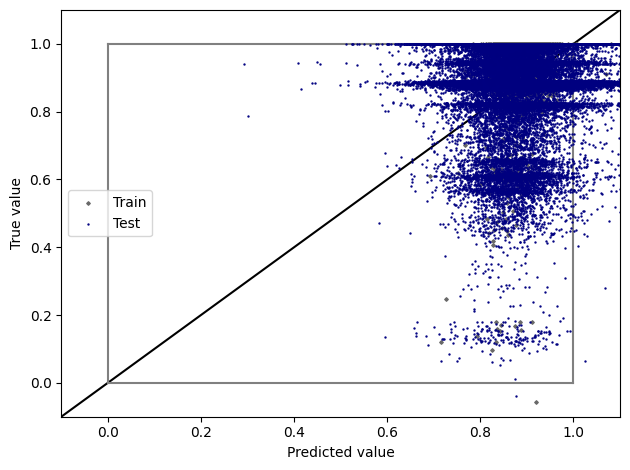

In [ ]:
plot_train_val(y_pred_train, y_train, y_pred_2017, y_2017)

In [ ]:
vif(X_train,10)

            feature          VIF
17        total_acc  2240.626922
51         num_sats  2185.408541
15         open_acc  2179.099009
2        int_rate_n  2101.353179
10  fico_range_high   992.279640
49    num_rev_accts   846.331863
3       sub_grade_n   414.072112
47        num_il_tl   379.105137
5        annual_inc   328.209837
55   pct_tl_nvr_dlq   256.712180


# 4 . Método Tradicional

## 4.1 Árvore de Decisão

A árvore foi definida em nível que permita a interpretabilidade da segmentação

Abaixo o modelo processado para amostras de 2%, 10% e 100% da base. A única limitação foi de que cada folha representasse pelo menos 2,5% da amostra. 

In [12]:
# Valor do empréstimo em milhares de dólares e criação da variável EAD e EAD/Renda
df1['ead'] = (df1['loan_amnt']-df1['total_rec_prncp'])/1000
df1['ead_inc'] = (df1['loan_amnt']-df1['total_rec_prncp'])/df1['annual_inc']
df1['ead_inc'] = np.where(df1['ead_inc'] > 30, 30, df1['ead_inc']) # 89 censurados
df1['ead_loan'] = (df1['loan_amnt']-df1['total_rec_prncp'])/df1['loan_amnt']
df1['loan_amnt'] = df1['loan_amnt']/1000
df1['dti'] = np.where(df1['dti']>200, 200, df1['dti']) #56 censurados

df1.shape #(266515, 115)

(266515, 115)

### 4.1.1 Processamento recursivo do bloco

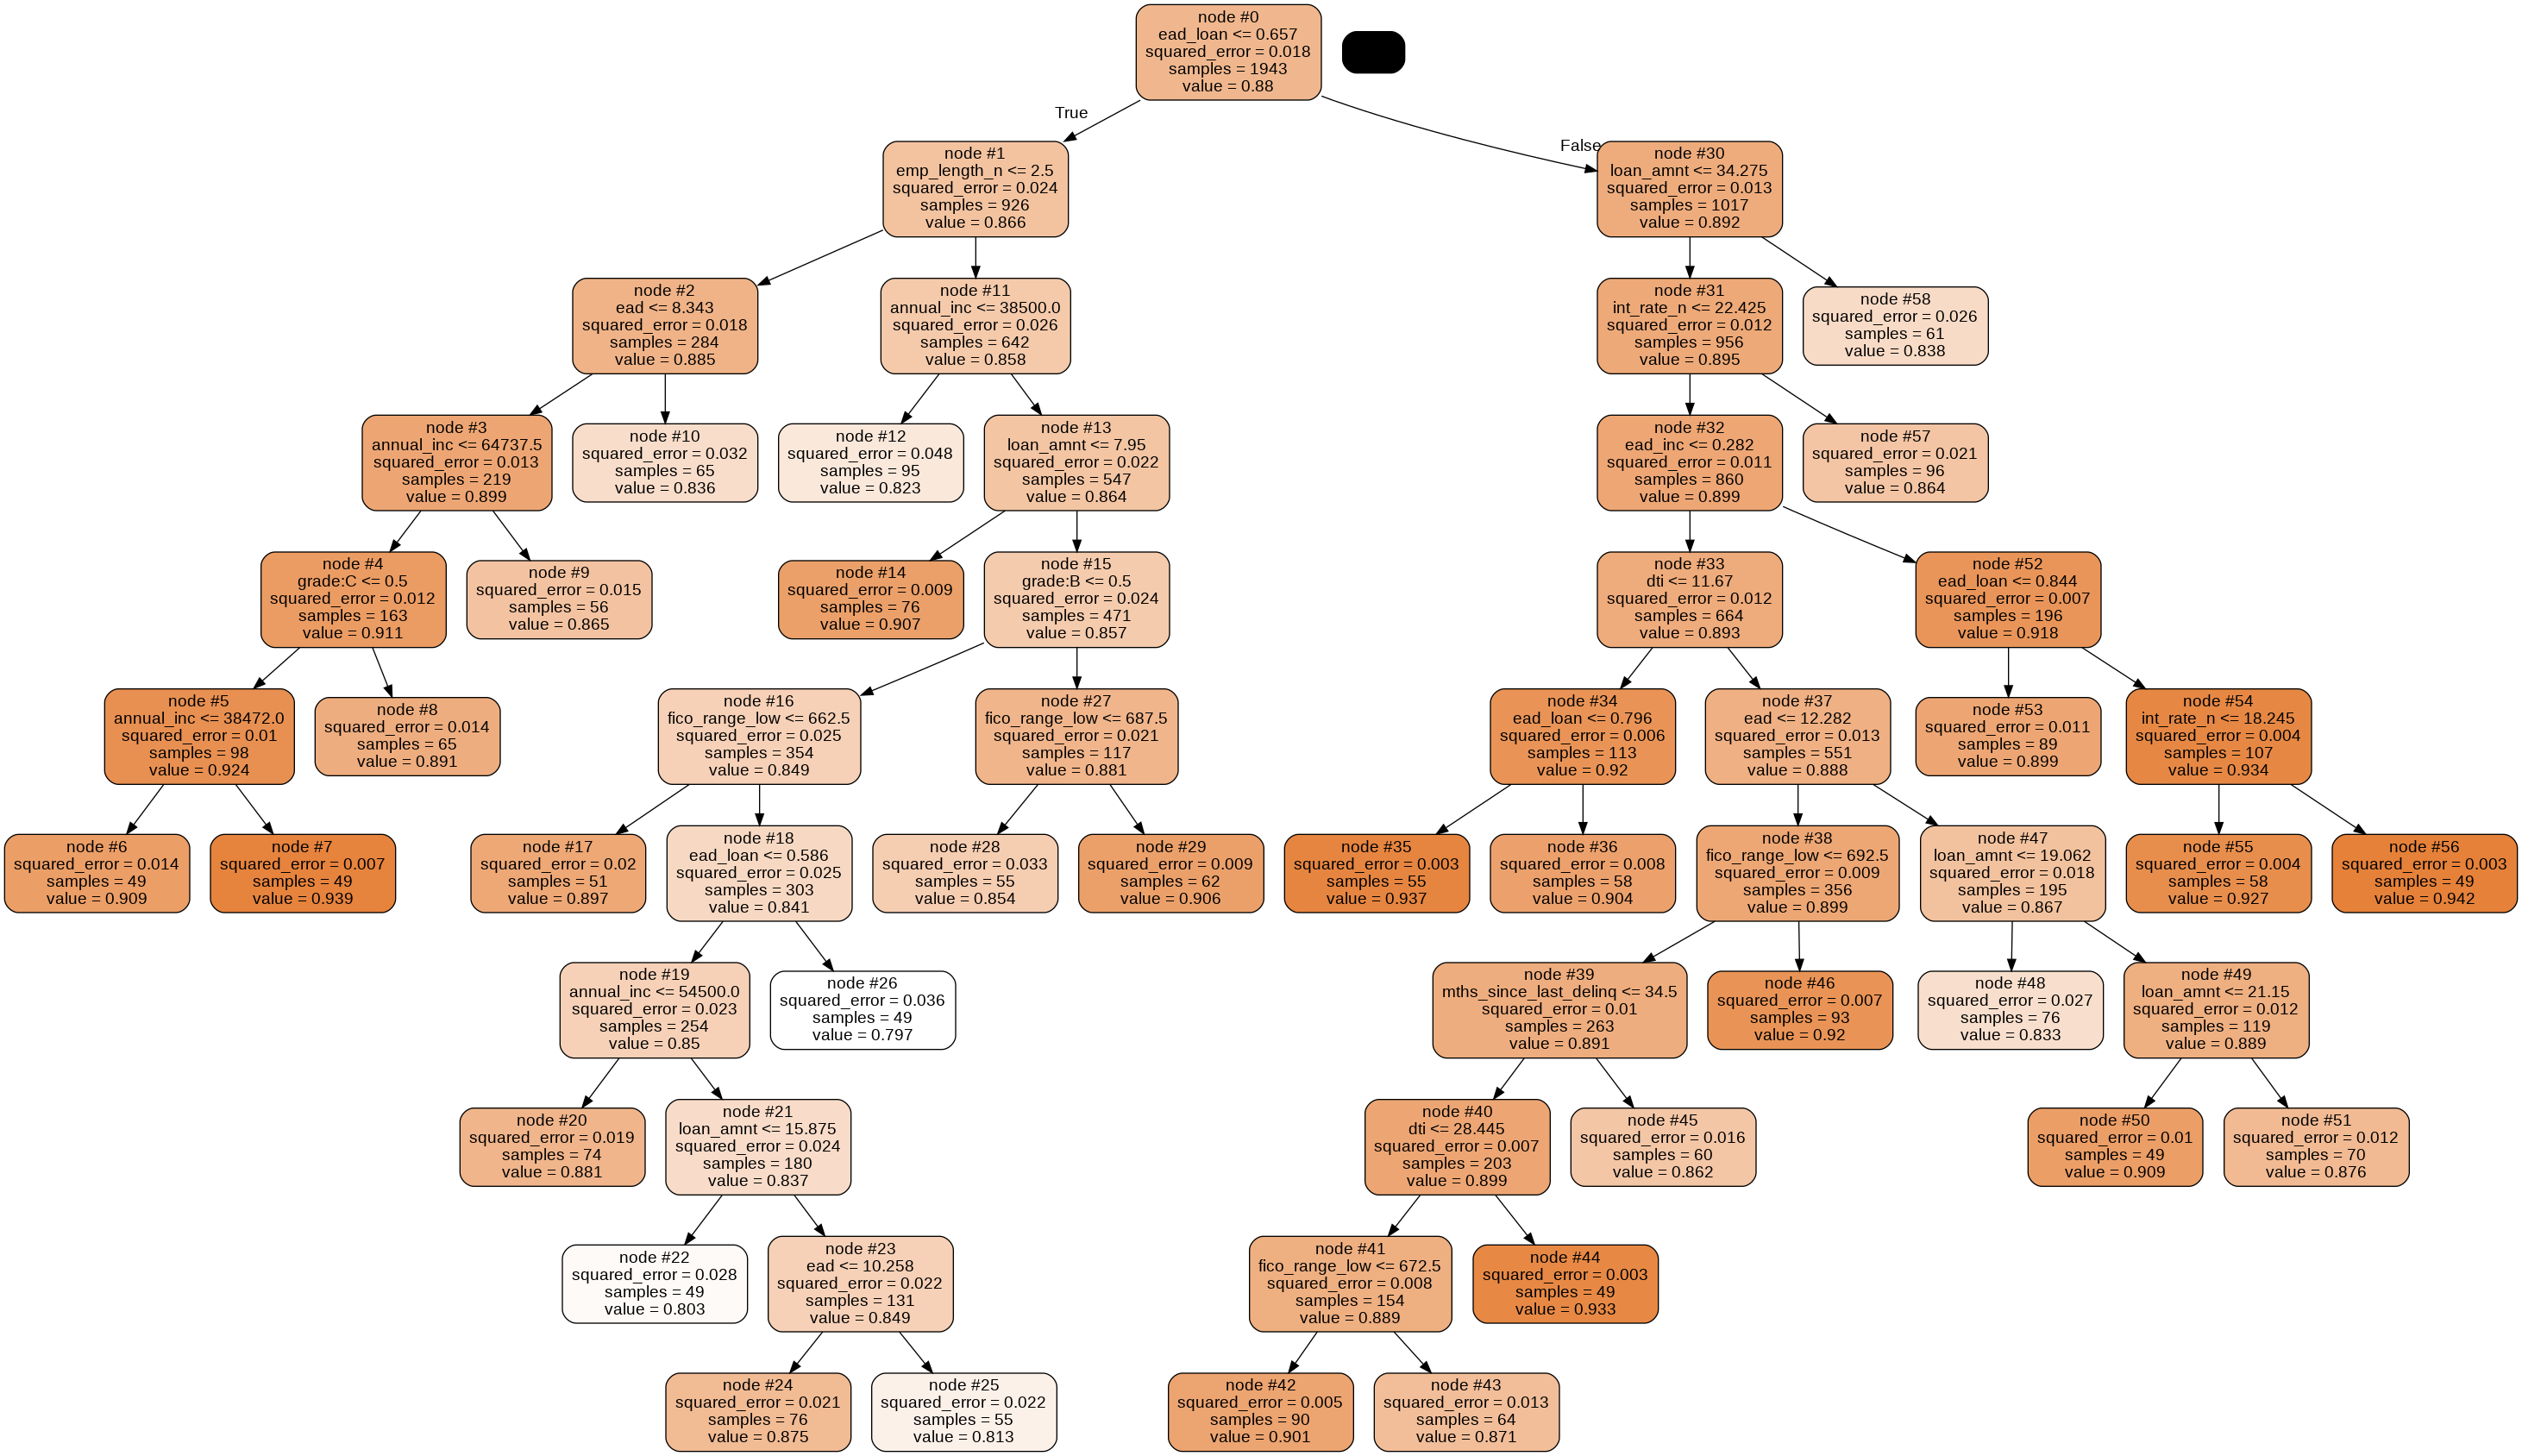

In [13]:
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function

# Separa as amostras iniciais
df_des = df1[df1.year.isin([2014,2015])].drop(columns=['year'])
#df_des = df_des.sample(frac =.10, replace = False, random_state = 2) #10%
df_des = df_des.sample(frac =.02, replace = False, random_state = 2) #2%

# Separa as amostras de validação out-of-time
df_2016 = df1[df1['year']==2016].drop(columns=['year'])
df_2017 = df1[df1['year']==2017].drop(columns=['year'])

feature_cols = ['loan_amnt','term_c','int_rate_n','ead','ead_inc','ead_loan','emp_length_n',\
                'annual_inc','dti','delinq_2yrs','mths_since_last_delinq','mths_since_last_delinq_null',\
                'pub_rec','inq_last_12m','fico_range_high', 'fico_range_low', 'grade:A','grade:B','grade:C','grade:D',\
                'grade:E','grade:F','home_ownership:ANY','home_ownership:MORTGAGE','home_ownership:OWN',\
                'purpose:car','purpose:credit_card','purpose:debt_consolidation','purpose:home_improvement',\
                'purpose:house','purpose:major_purchase','purpose:medical','purpose:moving',\
                'purpose:other','purpose:renewable_energy','purpose:vacation']
                
X = df_des[feature_cols].to_numpy() 
y = df_des[['lgd']].to_numpy() # Target variable
X_2016 = df_2016[feature_cols].to_numpy() 
y_2016 = df_2016[['lgd']].to_numpy() 
X_2017 = df_2017[feature_cols].to_numpy() 
y_2017 = df_2017[['lgd']].to_numpy() 

# Determinação da amostra de treinamento e  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=120) # 80% training and 20% test
# Create Decision Tree Regressor object (resposta contínua)
clf = DecisionTreeRegressor(max_depth=10,min_samples_leaf=0.025, min_impurity_decrease=0.000001)
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
# Predict the response for test dataset
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_2016 = clf.predict(X_2016)
y_pred_2017 = clf.predict(X_2017)

# Gera o gráfico da estrutura da árvore
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=False,leaves_parallel=False,proportion=False,rotate=False, node_ids=True, feature_names = feature_cols),
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('lgd.png')
Image(graph.create_png())

In [14]:
reg_metrics(y_train, y_pred_train, X_train)
reg_metrics(y_test, y_pred_test, X_test)
reg_metrics(y_2016, y_pred_2016, X_2016)
reg_metrics(y_2017, y_pred_2017, X_2017)

mae: 0.0887918 rmse: 0.1297481 R2: 0.0824679 R2_Ajustado: 0.0651378 Qtd: 1943 r: 0.2871722 rho: 0.2444757 tau: 0.171606
mae: 0.094717 rmse: 0.1361641 R2: -0.1066087 R2_Ajustado: -0.1953346 Qtd: 486 r: -0.0212156 rho: 0.0534355 tau: 0.036054
mae: 0.0936296 rmse: 0.1348469 R2: -0.0808547 R2_Ajustado: -0.0813475 Qtd: 78998 r: 0.0160539 rho: 0.0503466 tau: 0.0350098
mae: 0.0807093 rmse: 0.1157181 R2: -0.1694675 R2_Ajustado: -0.1701049 Qtd: 66083 r: -0.0189456 rho: 0.0242577 tau: 0.0169485


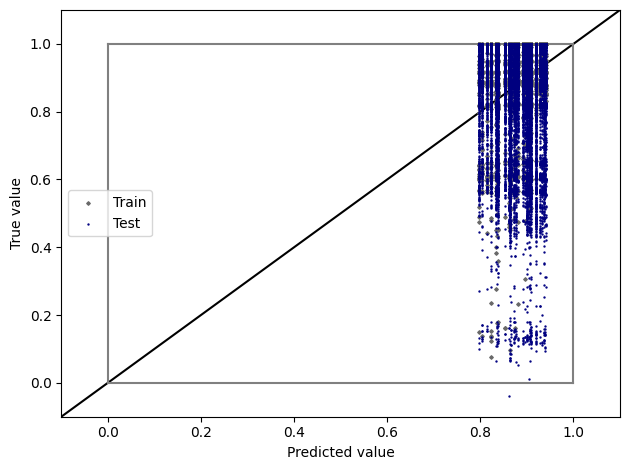

In [15]:
plot_train_val(y_pred_train, y_train, y_pred_2017, y_2017)

## 4.2 Regressão linear

Aqui foram feitos os mesmos tratamentos detalhados no item 3.2.

Abaixo o modelo processado para amostras de 2%, 10% e 100% da base.

In [16]:
# Trata algumas variáveis contínuas com domínio fora de 0-1
df1['loan_amnt'] = np.log(df1['loan_amnt'])
df1['int_rate_n'] = np.log(df1['int_rate_n'])
df1['ead'] = np.log(df1['ead'])

# Dividido por 1000, para deixar a renda em milhares de dólares anuais, censurando
df1['annual_inc'] = np.where(df1['annual_inc']<100, 100, df1['annual_inc']) #87 casos <$100
df1['annual_inc'] = np.where(df1['annual_inc']>1000000, 1000000, df1['annual_inc']) #40 casos >$1M
df1['annual_inc'] = df1['annual_inc']/1000 
df1['annual_inc'] = np.log(df1['annual_inc'])


### 4.2.1 Processamento recursivo do bloco

A analise aqui é feita em 2 etapas:

1. O modelo inteiro é processado, e são excluídas individualmente as variáveis com p-valor > 0.05. 
2. o conjunto final é avalido o `VIF` e variáveis muito correlacionadas são retiradas, partindo daquelas com maior p-valor e cujo VIF seja > 20.

Não foram excluídas as variáveis com sinal diferente do esperado. Elas serão discutidas no resultado.

In [129]:
import statsmodels.api as sm

# Separa as amostras iniciais
# ----------------------------------------
df_des = df1[df1.year.isin([2014,2015])].drop(columns=['year'])
des_train=df_des.sample(frac=0.8,random_state=2)
des_test=df_des.drop(des_train.index)

#df_des = df_des.sample(frac =.10, replace = False, random_state = 2) #10%
#des_train=df_des.sample(frac=0.8,random_state=2)
#des_test=df_des.drop(des_train.index)

#df_des = df_des.sample(frac =.02, replace = False, random_state = 2) #2%
#des_train=df_des.sample(frac=0.8,random_state=2)
#des_test=df_des.drop(des_train.index)

# Separa as amostras de validação out-of-time
df_2016 = df1[df1['year']==2016].drop(columns=['year'])
df_2017 = df1[df1['year']==2017].drop(columns=['year'])

#feature_cols = ['loan_amnt','term_c','int_rate_n','ead','ead_inc','ead_loan','emp_length_n',\
#                'annual_inc','dti','delinq_2yrs','mths_since_last_delinq','mths_since_last_delinq_null',\
#                'pub_rec','inq_last_12m','fico_range_high', 'fico_range_low', 'grade:A','grade:B','grade:C','grade:D',\
#                'grade:E','grade:F','home_ownership:ANY','home_ownership:MORTGAGE','home_ownership:OWN',\
#                'purpose:car','purpose:credit_card','purpose:debt_consolidation','purpose:home_improvement',\
#                'purpose:house','purpose:major_purchase','purpose:medical','purpose:moving',\
#                'purpose:other','purpose:renewable_energy','purpose:vacation']

feature_cols = ['term_c','ead_loan','emp_length_n',\
                'dti','delinq_2yrs','mths_since_last_delinq_null',\
                'pub_rec', 'grade:B','grade:C','grade:D',\
                'home_ownership:MORTGAGE','home_ownership:OWN',\
                'purpose:debt_consolidation',\
                'purpose:house',\
                'purpose:other']

X_train = des_train[feature_cols]
y_train = des_train[['lgd']]
y_train.rename(columns = {'lgd':'y'}, inplace = True)
X_test = des_test[feature_cols] 
y_test = des_test[['lgd']]
y_test.rename(columns = {'lgd':'y'}, inplace = True)
X_2016 = df_2016[feature_cols] 
y_2016 = df_2016[['lgd']] 
y_2016.rename(columns = {'lgd':'y'}, inplace = True)
X_2017 = df_2017[feature_cols] 
y_2017 = df_2017[['lgd']] 
y_2017.rename(columns = {'lgd':'y'}, inplace = True)
                     
# Processamento geral para avaliar o primeiro processamento da base.
# Interessante notar que não há a necessidade de converter para estrutura Numpy
results = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(results.summary())

y_pred_train = results.predict(sm.add_constant(X_train))
y_pred_test = results.predict(sm.add_constant(X_test))
y_pred_2016 = results.predict(sm.add_constant(X_2016))
y_pred_2017 = results.predict(sm.add_constant(X_2017))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     52.60
Date:                Sat, 15 Oct 2022   Prob (F-statistic):          8.93e-158
Time:                        20:11:47   Log-Likelihood:                 60062.
No. Observations:               97147   AIC:                        -1.201e+05
Df Residuals:                   97131   BIC:                        -1.199e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [130]:
reg_metrics(y_train, y_pred_train, X_train)
reg_metrics(y_test, y_pred_test, X_test)
reg_metrics(y_2016, y_pred_2016, X_2016)
reg_metrics(y_2017, y_pred_2017, X_2017)

mae: 0.0871384 rmse: 0.1303933 R2: 0.0080575 R2_Ajustado: 0.0079043 Qtd: 97147 r: 0.0897638 rho: 0.0400481 tau: 0.0277912
mae: 0.0870648 rmse: 0.1313764 R2: 0.0077833 R2_Ajustado: 0.0071701 Qtd: 24287 r: 0.0882837 rho: 0.0496196 tau: 0.0343787
mae: 0.0838692 rmse: 0.1294032 R2: 0.0046507 R2_Ajustado: 0.0044617 Qtd: 78998 r: 0.0726975 rho: 0.0819318 tau: 0.0570233
mae: 0.0689717 rmse: 0.1088388 R2: -0.0345532 R2_Ajustado: -0.0347881 Qtd: 66083 r: -0.0317609 rho: -0.0494111 tau: -0.0333847


In [131]:
vif(X_train,5)

                       feature  VIF
1                     ead_loan  6.7
3                          dti  5.6
2                 emp_length_n  3.0
12  purpose:debt_consolidation  2.9
0                       term_c  2.3


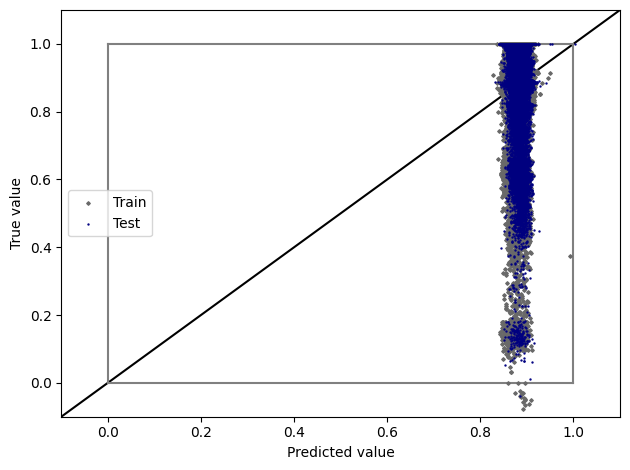

In [132]:
plot_train_val(y_pred_train, y_train, y_pred_2017, y_2017)

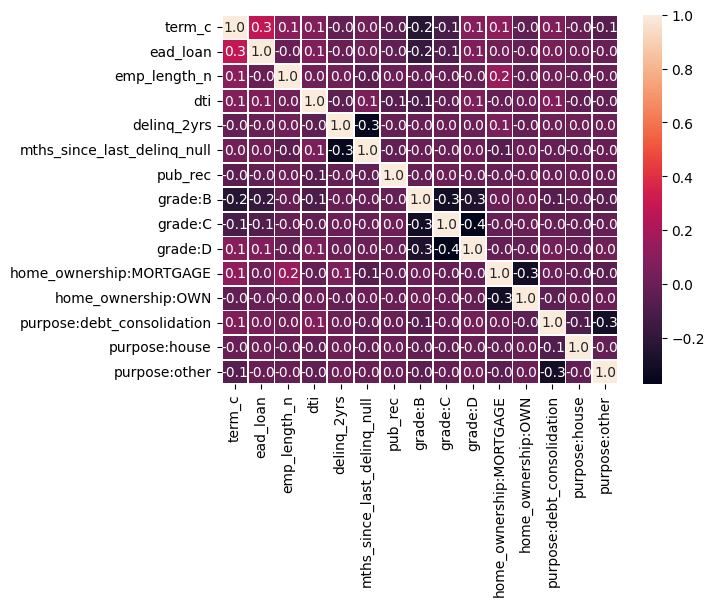

In [137]:
import seaborn as sn
plot = sn.heatmap(X_train.corr(), annot = True, fmt=".1f", linewidths=.6)
plot